In [2]:
import os
import numpy as np

import pyedflib

In [3]:
data_set = set([it.replace(".json", "") for it in os.listdir("ecg_data") if it.endswith('.json')]) & set([it.replace(".edf", "") for it in os.listdir("ecg_data") if it.endswith('.edf')])
# data_list = [os.path.join("ecg_data", it) for it in data_set]
# edf_file_list

In [4]:
data_dict = dict()
for key in data_set:
    data_dict[key] = dict()
    data_dict[key]['json_path'] = os.path.join("ecg_data",key + ".json")
    data_dict[key]['edf_path'] = os.path.join("ecg_data",key + ".edf")

In [5]:
import pandas as pd

In [6]:
import json

In [0]:

# pd.DataFrame(columns=pd.DataFrame(pd.read_json(open(data_dict[list(data_dict.keys())[0]]['json_path']),orient='columns',
#                            typ='series', dtype=False)).T.columns)

In [7]:
df_targets = pd.DataFrame()
for patient in data_dict:
    df_buffer = pd.DataFrame(pd.read_json(open(data_dict[patient]['json_path']),orient='columns',
                           typ='series', dtype=False))
    df_buffer = df_buffer.T
    df_buffer['patient'] = patient
    #   df_buffer['patient'] = patient
    df_targets = df_targets.append(df_buffer.set_index('patient'))

In [8]:
df_numeric_targets = df_targets.applymap(lambda x: int(x))

In [24]:
df_numeric_targets.head()

,left_ventricular_hypertrophy,sinus_tachycardia,normal,nodal_rhythm,AV_blockade_III_st,atrial_rhythm,abnormalities_Q_right ventricle,AV_dissociation,impaired_T_wave_lead_i,CA_blockade,...,nodal,WPW_syndrome,sharp_right_deviation,MI_with_ST_lift_rear_wall,incomplete_left_bundle_branch_blockade,extended_QT_interval,impaired_T_wave_lead_ii,horizontal,elongated_PQ,atrial_flutter
patient,,,,,,,,,,,,,,,,,,,,,
1102530574,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1102531056,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50455077,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1102609816,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1102526384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
import matplotlib.pyplot as plt

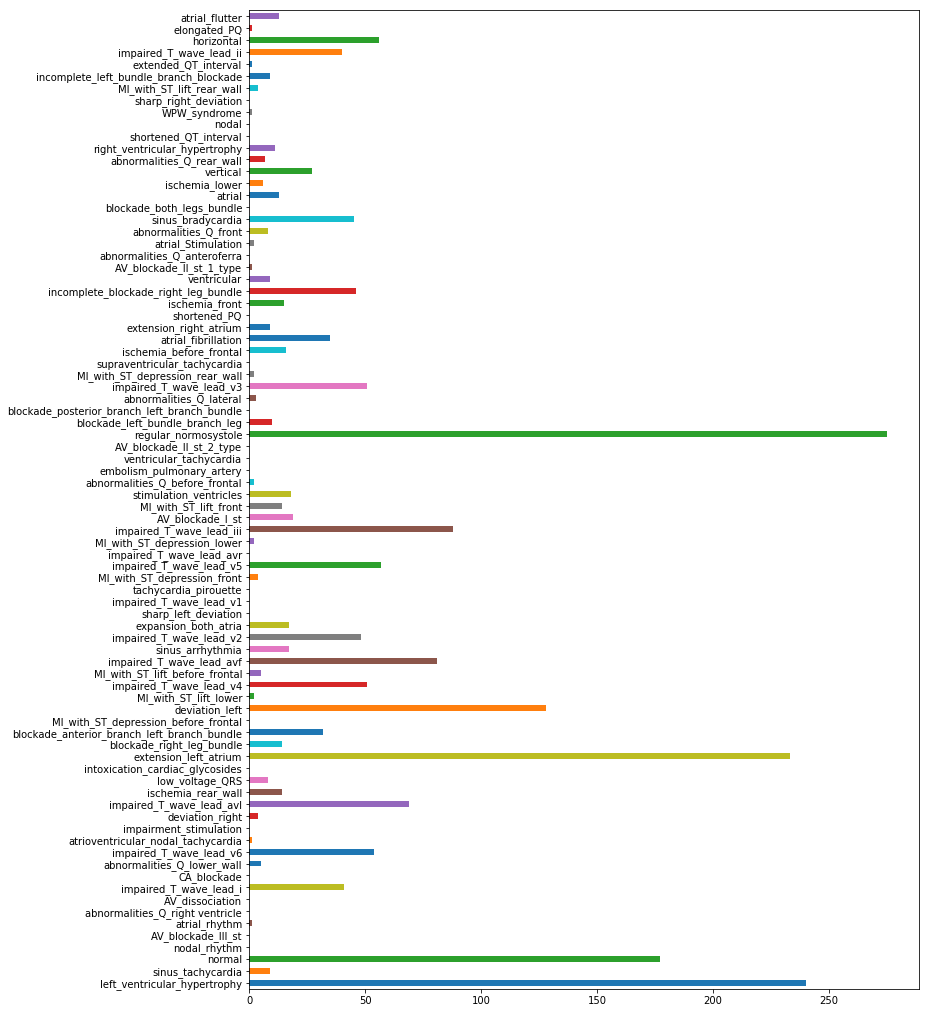

In [10]:
plt.figure(figsize=(12, 18))
df_numeric_targets.sum(axis=0).plot.barh()
pass

In [11]:
print("Количество пересекающихся диагнозов: {0}".format(len(df_numeric_targets.columns)))

Количество пересекающихся диагнозов: 82


In [12]:
print("Количество пациентов без какого-либо диагноза: {0}".format(df_numeric_targets[df_numeric_targets.sum(axis=1)<1].shape[0]))

Количество пациентов без какого-либо диагноза: 0


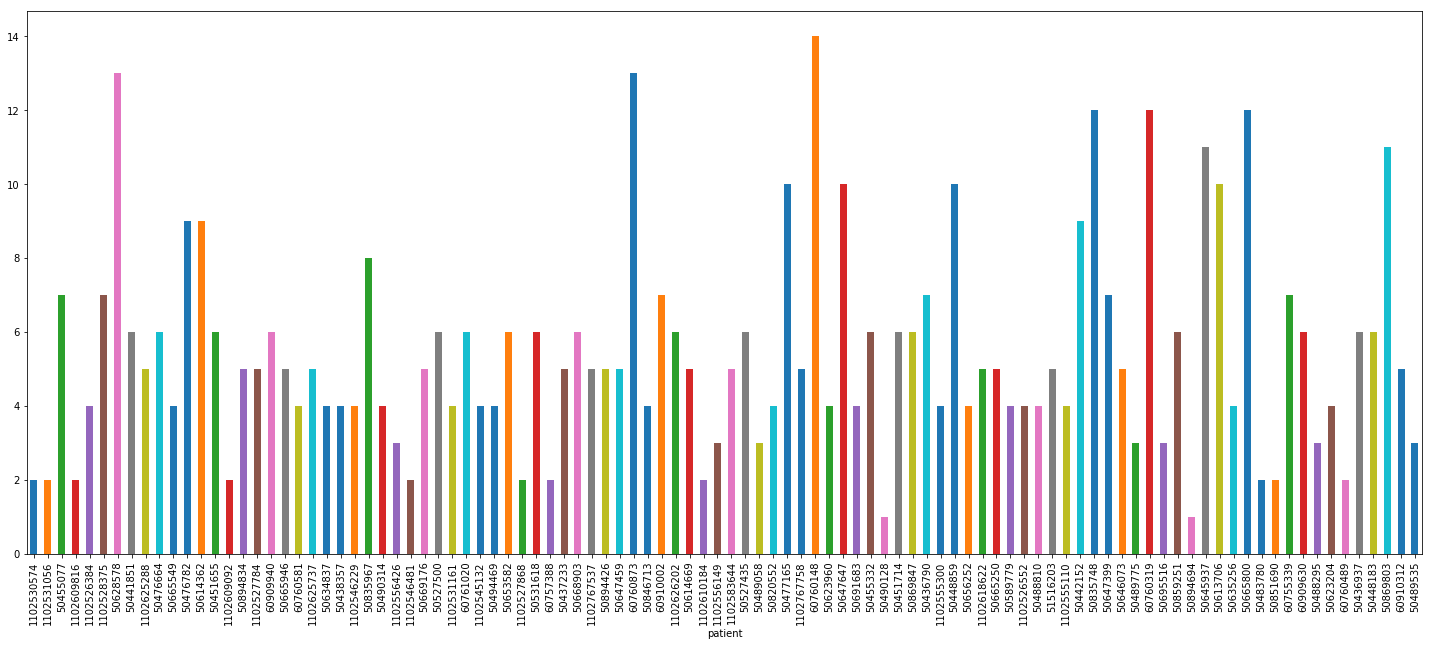

In [13]:
plt.figure(figsize=(25, 10))
df_numeric_targets.iloc[:100].sum(axis=1).plot.bar()

# Теперь давайте посмотрим на диагнозы более верхнеуровнево


---




In [14]:
diagnosis_dict_list = json.load(open("ecg_data/diagnosis.json"))

In [15]:
print("Количество категорий диагнозов: {0}".format(len([it['type'] for it in diagnosis_dict_list if it['type']=='category'])))

Количество категорий диагнозов: 12


In [16]:
[it.update({'1st_level_category':'PQ_characteristics',
            '1st_level_cat_desc':'P-Q особенности',
            '2nd_level_category':'PQ_characteristics',
            '2nd_level_cat_desc':'P-Q особенности'}) for it in diagnosis_dict_list if it['type']!='category']
print("Не категориальные диагнозы категоризуем вручную:")
[it for it in diagnosis_dict_list if it['type']!='category']

Не категориальные диагнозы категоризуем вручную:


[{'name': 'shortened_PQ',
  'type': 'diagnosis',
  'value': 'Укороченный P-Q',
  'level': 'yellow',
  '1st_level_category': 'PQ_characteristics',
  '1st_level_cat_desc': 'P-Q особенности',
  '2nd_level_category': 'PQ_characteristics',
  '2nd_level_cat_desc': 'P-Q особенности'},
 {'name': 'elongated_PQ',
  'type': 'diagnosis',
  'value': 'Удлиненный P-Q',
  'level': 'yellow',
  '1st_level_category': 'PQ_characteristics',
  '1st_level_cat_desc': 'P-Q особенности',
  '2nd_level_category': 'PQ_characteristics',
  '2nd_level_cat_desc': 'P-Q особенности'}]

## Приведем два уровня иерархии категорий для каждого диагноза

In [21]:
categorised_diagnosis_dict = dict()
for cat_dict in [it for it in diagnosis_dict_list]:
    if cat_dict['type'] != 'diagnosis':
        for diagnose_dict in cat_dict['value']:
            if diagnose_dict['type']!='diagnosis':
                for _sub_dict in diagnose_dict['value']:
                    _dict = dict()
                    _dict['1st_level_category'] = cat_dict['name']
                    _dict['1st_level_cat_desc'] = cat_dict['description']
                    _dict['2nd_level_category'] = diagnose_dict['name']
                    _dict['2nd_level_cat_desc'] = diagnose_dict['description']
                    _dict['alert_level'] = _sub_dict['level']
                    _dict['diagnose_desc'] = _sub_dict['value']
                    categorised_diagnosis_dict[_sub_dict['name']] = _dict
            else:
                _dict = dict()
                _dict['1st_level_category'] = cat_dict['name']
                _dict['1st_level_cat_desc'] = cat_dict['description']
                _dict['2nd_level_category'] = cat_dict['name']
                _dict['2nd_level_cat_desc'] = cat_dict['description']
                _dict['alert_level'] = diagnose_dict['level']
                _dict['diagnose_desc'] = diagnose_dict['value']
                categorised_diagnosis_dict[diagnose_dict['name']] = _dict
    else:
        _dict = dict()
        _dict['1st_level_category'] = cat_dict['1st_level_category']
        _dict['1st_level_cat_desc'] = cat_dict['1st_level_cat_desc']
        _dict['2nd_level_category'] = cat_dict['2nd_level_category']
        _dict['2nd_level_cat_desc'] = cat_dict['2nd_level_cat_desc']
        _dict['alert_level'] = cat_dict['level']
        _dict['diagnose_desc'] = cat_dict['value']
        categorised_diagnosis_dict[cat_dict['name']] = _dict
    #     print(cat_dict)

In [22]:
# Проверим что разметили категории для всех диагнозов
set(categorised_diagnosis_dict.keys()) ^ set(df_numeric_targets.columns)

set()

## Имея маппинг диагнозов на категории, можем проанализировать распределение целевых значений по группам

In [25]:
target_set_1st_lvl = set([categorised_diagnosis_dict[it]['1st_level_category'] for it in categorised_diagnosis_dict])
target_set_2nd_lvl = set([categorised_diagnosis_dict[it]['2nd_level_category'] for it in categorised_diagnosis_dict])
target_set_color_lvl = set([categorised_diagnosis_dict[it]['alert_level'] for it in categorised_diagnosis_dict])

In [26]:
len(target_set_2nd_lvl)

17

In [27]:
df_categorised_targets_1st_level = pd.DataFrame(columns=list(target_set_1st_lvl) + ['patient'])
df_categorised_targets_2nd_level = pd.DataFrame(columns=list(target_set_2nd_lvl) + ['patient'])
df_categorised_targets_color_level = pd.DataFrame(columns=list(target_set_color_lvl) + ['patient'])
for patient in df_numeric_targets.index:
    patient_series = df_numeric_targets.loc[patient]
    #   print(patient, patient_series[patient_series > 0].index)
    _diagnosis_1st_lvl_list = [categorised_diagnosis_dict[it]['1st_level_category'] for it in patient_series[patient_series > 0].index]
    pattern_1st_lvl = [_it if _it[0] not in _diagnosis_1st_lvl_list else (_it[0], 1) for _it in 
                     [it for it in 
                      zip(df_categorised_targets_1st_level.columns, 
                          [0]*len(target_set_1st_lvl) + [patient])]
                    ]
    _diagnosis_2nd_lvl_list = [categorised_diagnosis_dict[it]['2nd_level_category'] for it in patient_series[patient_series > 0].index]
    pattern_2nd_lvl = [_it if _it[0] not in _diagnosis_2nd_lvl_list else (_it[0], 1) for _it in 
                     [it for it in 
                      zip(df_categorised_targets_2nd_level.columns, 
                          [0]*len(target_set_2nd_lvl) + [patient])]
                    ]

    _diagnosis_color_lvl_list = [categorised_diagnosis_dict[it]['alert_level'] for it in patient_series[patient_series > 0].index]
    pattern_color_lvl = [_it if _it[0] not in _diagnosis_color_lvl_list else (_it[0], 1) for _it in 
                     [it for it in 
                      zip(df_categorised_targets_color_level.columns, 
                          [0]*len(target_set_color_lvl) + [patient])]
                    ]
    df_categorised_targets_1st_level = df_categorised_targets_1st_level.append(dict(pattern_1st_lvl), ignore_index=True)
    df_categorised_targets_2nd_level = df_categorised_targets_2nd_level.append(dict(pattern_2nd_lvl), ignore_index=True)
    df_categorised_targets_color_level = df_categorised_targets_color_level.append(dict(pattern_color_lvl), ignore_index=True)
    #   print(pattern_1st_lvl)
    #   print(pattern_2nd_lvl)


    #   break

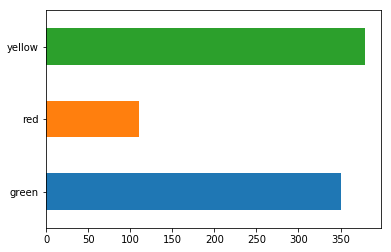

In [28]:
df_categorised_targets_color_level.set_index('patient').sum(axis=0).plot.barh()
plt.show()

In [29]:
df_categorised_targets_color_level.set_index('patient').head()

,green,red,yellow
patient,,,
1102530574,1,0,0
1102531056,1,0,0
50455077,0,0,1
1102609816,1,0,0
1102526384,1,1,1


In [30]:
df_categorised_targets_color_level.set_index('patient').shape

(410, 3)

In [31]:
from easyesn import ClassificationESN

In [ ]:
esn = ClassificationESN(12,250,3,)

In [ ]:
## Построим Multilabel Classification model для самого простого случая

In [181]:
df_numeric_targets.head()

,AV_blockade_III_st,AV_blockade_II_st_1_type,AV_blockade_II_st_2_type,AV_blockade_I_st,AV_dissociation,CA_blockade,MI_with_ST_depression_before_frontal,MI_with_ST_depression_front,MI_with_ST_depression_lower,MI_with_ST_depression_rear_wall,...,shortened_QT_interval,sinus_arrhythmia,sinus_bradycardia,sinus_tachycardia,stimulation_ventricles,supraventricular_tachycardia,tachycardia_pirouette,ventricular,ventricular_tachycardia,vertical
patient,,,,,,,,,,,,,,,,,,,,,
60760082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60909382,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1102625288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50527435,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
50455332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
f = pyedflib.EdfReader(file_list[-1])
# print("filetype: %i\n"%hdr.filetype);
print("edfsignals: %i" % f.signals_in_file)
print("file duration: %i seconds" % f.file_duration)
print("startdate: %i-%i-%i" % (f.getStartdatetime().day,f.getStartdatetime().month,f.getStartdatetime().year))
print("starttime: %i:%02i:%02i" % (f.getStartdatetime().hour,f.getStartdatetime().minute,f.getStartdatetime().second))
# print("patient: %s" % f.getP);
# print("recording: %s" % f.getPatientAdditional())
print("patientcode: %s" % f.getPatientCode())
print("gender: %s" % f.getGender())
print("birthdate: %s" % f.getBirthdate())
print("patient_name: %s" % f.getPatientName())
print("patient_additional: %s" % f.getPatientAdditional())
print("admincode: %s" % f.getAdmincode())
print("technician: %s" % f.getTechnician())
print("equipment: %s" % f.getEquipment())
print("recording_additional: %s" % f.getRecordingAdditional())
print("datarecord duration: %f seconds" % f.getFileDuration())
print("number of datarecords in the file: %i" % f.datarecords_in_file)
print("number of annotations in the file: %i" % f.annotations_in_file)

channel = 3
print("\nsignal parameters for the %d.channel:\n\n" % channel)

print("label: %s" % f.getLabel(channel))
print("samples in file: %i" % f.getNSamples()[channel])
# print("samples in datarecord: %i" % f.get
print("physical maximum: %f" % f.getPhysicalMaximum(channel))
print("physical minimum: %f" % f.getPhysicalMinimum(channel))
print("digital maximum: %i" % f.getDigitalMaximum(channel))
print("digital minimum: %i" % f.getDigitalMinimum(channel))
print("physical dimension: %s" % f.getPhysicalDimension(channel))
print("prefilter: %s" % f.getPrefilter(channel))
print("transducer: %s" % f.getTransducer(channel))
print("samplefrequency: %f" % f.getSampleFrequency(channel))

annotations = f.readAnnotations()
for n in np.arange(f.annotations_in_file):
    print("annotation: onset is %f    duration is %s    description is %s" % (annotations[0][n],annotations[1][n],annotations[2][n]))

buf = f.readSignal(channel)
n = 200
print("\nread %i samples\n" % n)
result = ""
for i in np.arange(n):
    result += ("%.1f, " % buf[i])
# print(result)
# print(f.__dict__)
f._close()
del f